<a href="https://colab.research.google.com/github/viddev1/tensorflow_notebooks/blob/main/tf_transfer_learning_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Wed May 25 02:57:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-25 02:57:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  97.0MB/s    in 1.7s    

2022-05-25 02:57:37 (97.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath} ")

There are 2 directories and 0 images in '10_food_classes_10_percent 
There are 10 directories and 0 images in '10_food_classes_10_percent/train 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger 
There are 0 directories and 75 images in '10_food_classes_10_percent/train/stea

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_shape = (224, 224)
batch_size = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=img_shape,
                                                          batch_size=batch_size,
                                                          class_mode='categorical')

print("testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=img_shape,
                                                          batch_size=batch_size,
                                                          class_mode='categorical')

training images:
Found 750 images belonging to 10 classes.
testing images:
Found 2500 images belonging to 10 classes.


In [6]:
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir, exp_name):
  log_dir = dir + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback =  tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard log files to: {log_dir}")
  return tensorboard_callback

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [9]:
def create_model(model_url, num_classes=10):
  fea_ext_layer = hub.KerasLayer(model_url,
                                 trainable=False,
                                 name='feature_extraction_layer',
                                 input_shape=img_shape+(3,)
                                 )
  model = tf.keras.Sequential([
                               fea_ext_layer,
                               layers.Dense(10, activation='softmax', name='output_layer')
  ])
  return model

In [10]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy']
                     )

In [11]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir="tensorflow_hub",
                                                                         exp_name="resnet50v2")])

saving tensorboard log files to: tensorflow_hub/resnet50v2/20220525-025758
Epoch 1/5
24/24 [==============================] - 42s 1s/step - loss: 2.1585 - accuracy: 0.3000 - val_loss: 1.3215 - val_accuracy: 0.5812
Epoch 2/5
24/24 [==============================] - 16s 695ms/step - loss: 1.0091 - accuracy: 0.7080 - val_loss: 0.9283 - val_accuracy: 0.6924
Epoch 3/5
24/24 [==============================] - 16s 701ms/step - loss: 0.6722 - accuracy: 0.7987 - val_loss: 0.7969 - val_accuracy: 0.7420
Epoch 4/5
24/24 [==============================] - 17s 715ms/step - loss: 0.5189 - accuracy: 0.8507 - val_loss: 0.7262 - val_accuracy: 0.7664
Epoch 5/5
24/24 [==============================] - 16s 705ms/step - loss: 0.4067 - accuracy: 0.9093 - val_loss: 0.6925 - val_accuracy: 0.7792


In [12]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='validation loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training accuracy')
  plt.plot(epochs, val_accuracy, label='validation accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

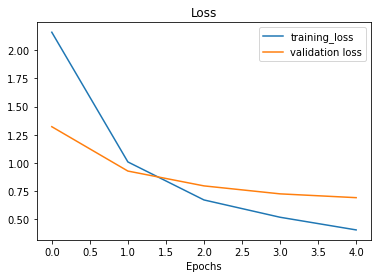

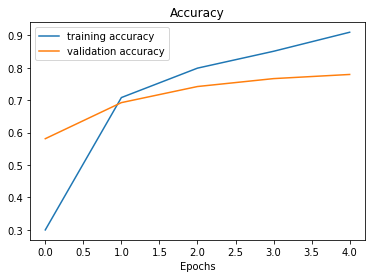

In [13]:
plot_loss_curves(resnet_history)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir="tensorflow_hub",
                                                                         exp_name="efficientnetB0")])

saving tensorboard log files to: tensorflow_hub/efficientnetB0/20220525-025957
Epoch 1/5
24/24 [==============================] - 34s 1s/step - loss: 1.8728 - accuracy: 0.4027 - val_loss: 1.2987 - val_accuracy: 0.7172
Epoch 2/5
24/24 [==============================] - 18s 776ms/step - loss: 1.0684 - accuracy: 0.7680 - val_loss: 0.8762 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 19s 819ms/step - loss: 0.7704 - accuracy: 0.8240 - val_loss: 0.7041 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 17s 752ms/step - loss: 0.6183 - accuracy: 0.8587 - val_loss: 0.6189 - val_accuracy: 0.8576
Epoch 5/5
24/24 [==============================] - 19s 795ms/step - loss: 0.5208 - accuracy: 0.8800 - val_loss: 0.5616 - val_accuracy: 0.8680


In [15]:
plot_loss_curves(efficientnet_history)

In [16]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [17]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF Hub Feature Extractor model actitectures using 10% of training data images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=46WEx4IliwekEFs1UNrvHFrKQtIrzS&prompt=consent&access_type=off

In [18]:
!tensorboard dev list

https://tensorboard.dev/experiment/xdjvTGB7SXKnZrrbj0GPSA/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub Feature Extractor model actitectures using 10% of training data images
	Id                   xdjvTGB7SXKnZrrbj0GPSA
	Created              2022-05-25 03:02:54 (3 minutes ago)
	Updated              2022-05-25 03:02:57 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918538
Total: 1 experiment(s)


In [19]:
!tensorboard dev delete --experiment_id xdjvTGB7SXKnZrrbj0GPSA

Deleted experiment xdjvTGB7SXKnZrrbj0GPSA.


In [20]:
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
